In [1]:
"""Created and Edited by James Alexander Adriano Aymer"""

#Data Handling Library
import pandas
import plotly
import data_handler as DATA

#Data Visualisation Library
import matplotlib.pyplot as pyplot
%matplotlib inline

"""Processing Libraries"""
from numpy import random, ndarray, matrix, c_, r_, ones, roll, transpose

#Data Scaling
import sklearn.preprocessing

#japanese data?
japanese = True

In [2]:
path = "..//Macro Data//%s%s.csv"
subpath = "GBR Macro Data//"
filename = "raw macro variables"

raw = pandas.read_csv(path%(subpath,filename) )
del raw["Unnamed: 0"]

In [3]:
#activate this cell to run for japan economy
if japanese:
    jpn = pandas.read_csv(path%("JPN Macro Data//",filename))
    del jpn["Unnamed: 0"]

    raw = jpn

In [4]:
"""Data Normalisation"""
#Set scaling limits to (zero -> one)
scaler = sklearn.preprocessing.MinMaxScaler((0,1))

#Scale the data
scaled = pandas.DataFrame(scaler.fit_transform(raw, (0,1)), columns=raw.columns)

In [5]:
"""Data Partitioning"""
#Prepares the Inputs
if not japanese:
    X_labels = scaled.columns[1:8].tolist() + scaled.columns[17:].tolist()
else:
    X_labels = scaled.columns[1:6] | scaled.columns[15:]
    
X_all = scaled[X_labels]

#Prepares the Targets
if not japanese:
    Y_labels = scaled.columns[8:17].tolist()
else:
    Y_labels = scaled.columns[6:15].tolist()
    
Y = scaled[Y_labels]

#reducing Y to just the gdp fluctuation graph
if not japanese:
    Y = Y['UK gdp at constant prices_% change']
else:
    Y = Y['JPN gdp at constant prices_% change']

#Prapares the Time vector
if not japanese:
    T_label = raw.columns[0]
else:
    T_label = raw.columns[0]
T = raw[T_label]

In [6]:
"""Feature Selection"""
#importing sklearn library
import sklearn.feature_selection as feature_selection

#chosing the selection algorithm
selector = feature_selection.SelectKBest(k=10)

#performing the selection
X = selector.fit_transform( X_all, Y ) 

In [7]:
#creating the macroeconomic feature score table
scores_list = list()
X_selected = list()
for score, name in zip(selector.scores_, X_all.columns):
    if(score>1): 
        scores_list.append(score)
        X_selected.append(name)
    else:
        continue
    

X_select = list()

print("Score\t\t\t\t\tFeature")
print("--------------------------------------------------------------------------")
for score, name in zip(scores_list, X_selected):
    print("\n%0.4f   \t\t%s"%(score, name))
    X_select.append(X_all[name])
    
X = pandas.DataFrame(transpose(X_select), columns=X_selected )

Score					Feature
--------------------------------------------------------------------------

8468.7786   		JPN current account balance_usd billions

36.6652   		JPN exports of goods and services_% change

133.0054   		JPN exports of goods_% change

1.0850   		JPN general government net debt_% of gdp

8.7919   		JPN general government net lending-borrowing_usd billions

63.0768   		JPN general government net lending_borrowing_% of gdp

4.0058   		JPN general government primary net lending-borrowing_usd billions

29.0116   		JPN general government primary net lending_borrowing_% of gdp billions

1.4742   		JPN general government revenue_% of gdp

7.5274   		JPN general government total expenditure_% of gdp

1.4420   		JPN gross national savings_% of gdp

17.9684   		JPN inflation % change_average consumer prices

2.3202   		JPN inflation index_average consumer prices

2.0392   		JPN inflation index_end of period consumer prices

926.3496   		JPN population_millions

1.0102   		JPN share

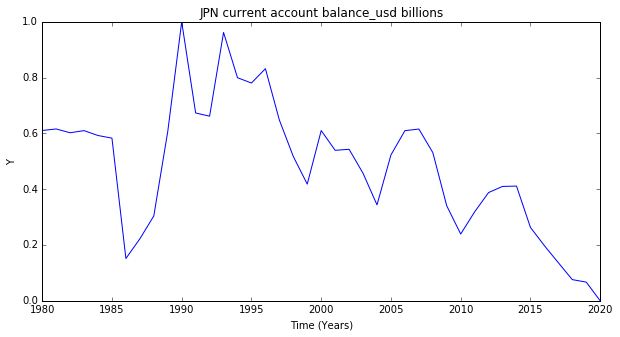

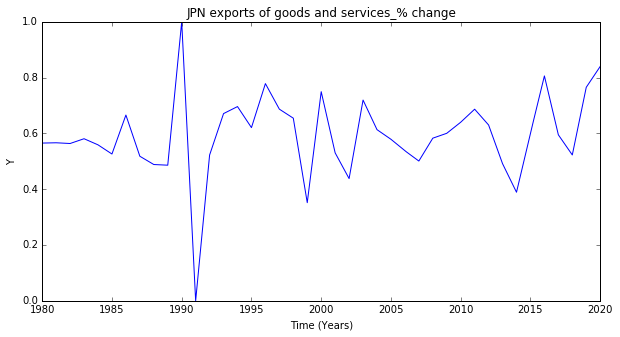

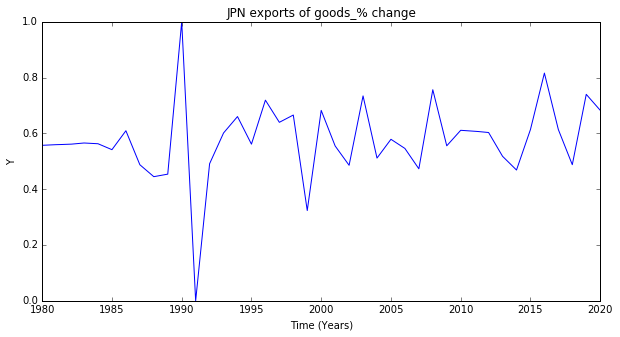

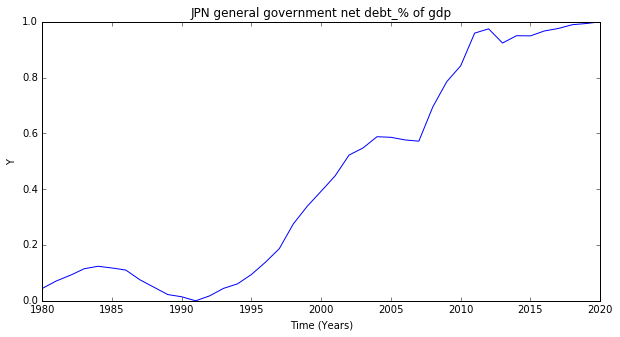

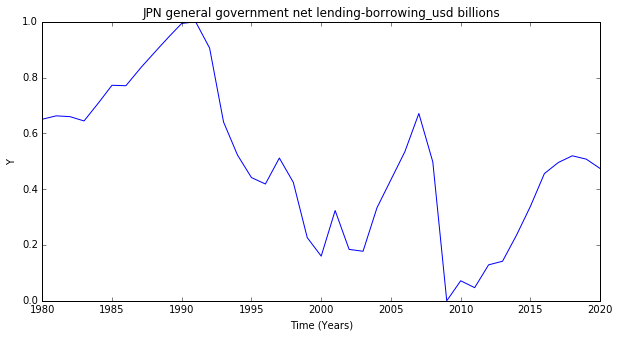

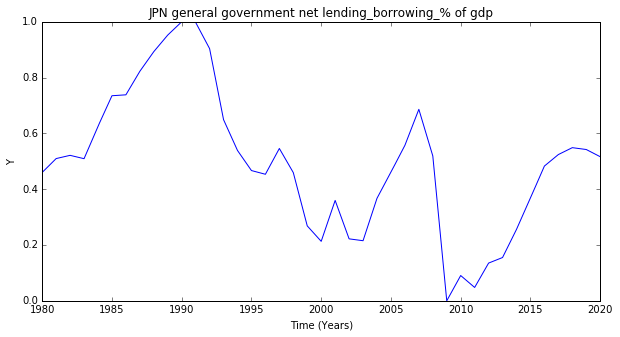

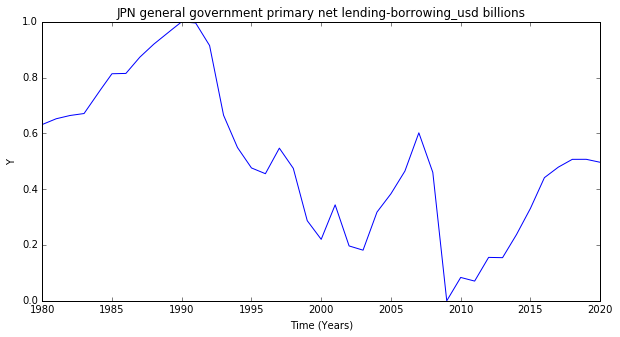

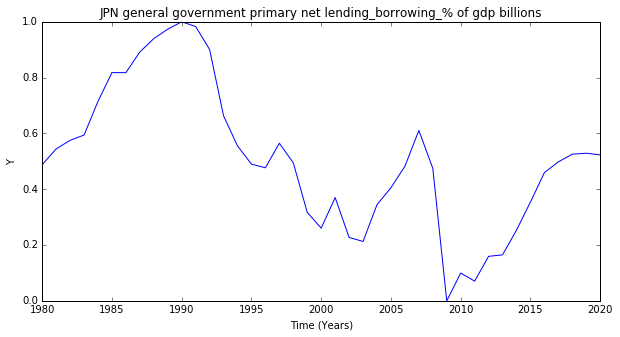

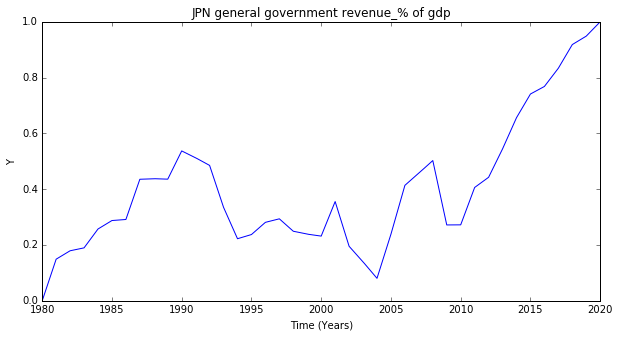

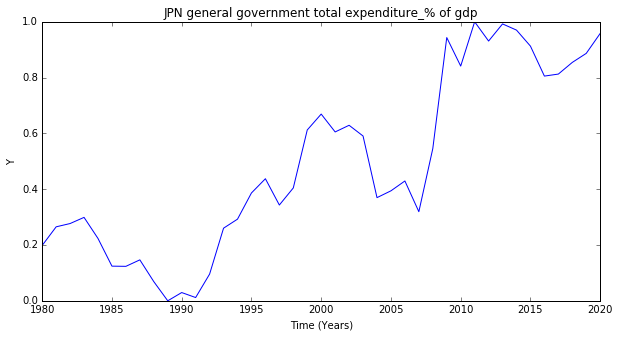

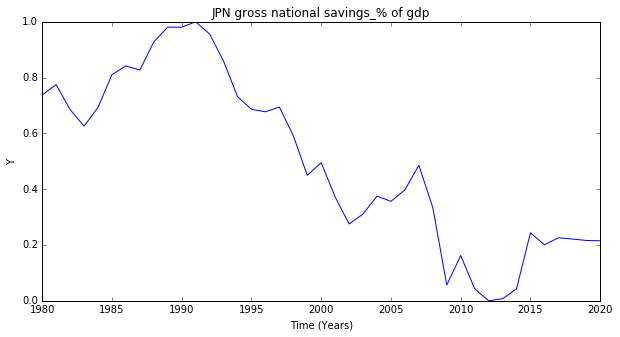

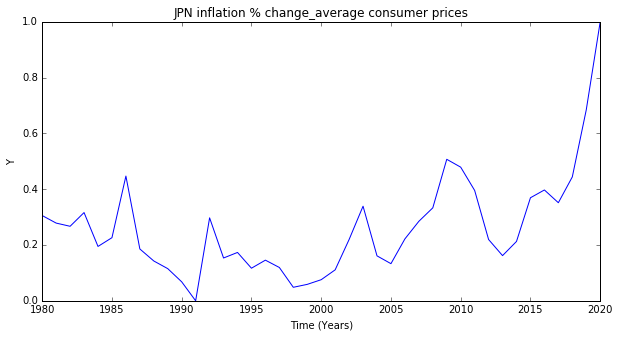

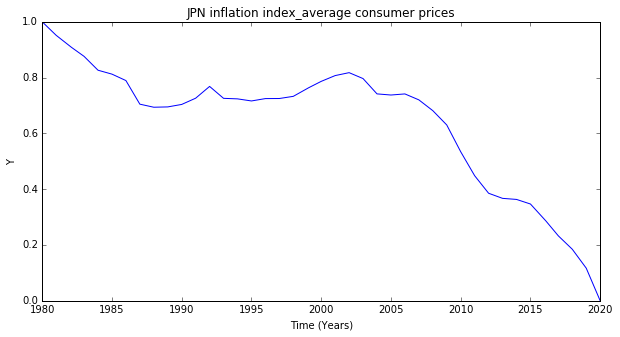

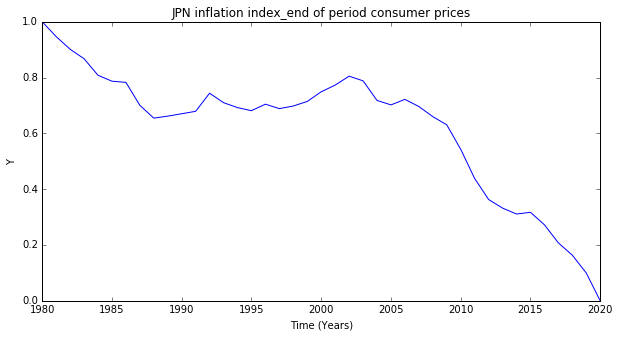

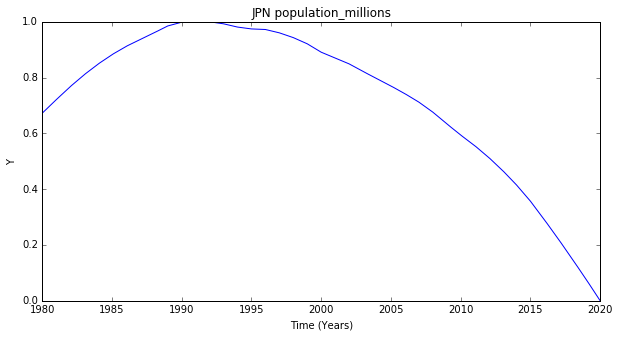

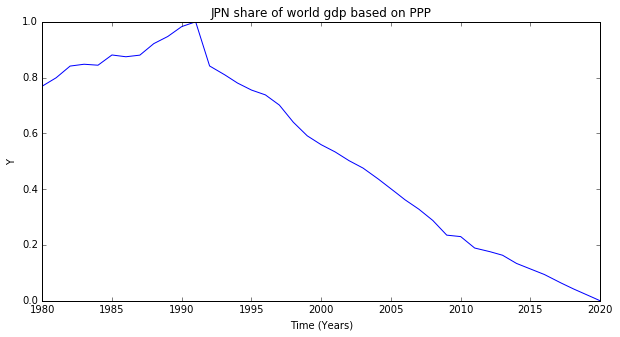

In [8]:
#displays all macroeconomic inputs to the network
for column, _ in enumerate(X): 
    pyplot.figure(figsize=(10,5))
    pyplot.plot(T, X.loc[:][X.columns[column]],'b')
    pyplot.xlabel("Time (Years)")
    pyplot.ylabel("Y")

    
    pyplot.title(X.columns[column])
    pyplot.show()

In [9]:
'''Train - Test partitioning'''
#paritionining into train and test sets
#training set = 80%; test set = 20%
X_train, Y_train, T_train, X_test, Y_test, T_test = DATA.train_test_split(X, Y, T, 0.8, overlap=0)

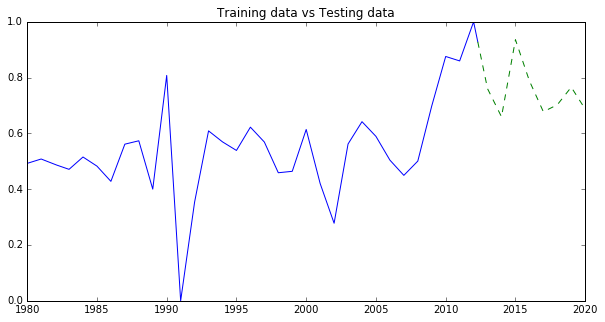

In [10]:
#Graphing the target (Y) data - gdp
pyplot.figure(figsize=(10,5))
pyplot.plot(T_train, Y_train)
pyplot.plot(T_test, Y_test, '--')
pyplot.title("Training data vs Testing data")
pyplot.show()

In [11]:
#setting up the Artificial Neural Network
import MultiLayerPerceptron as MLP
import random

#setting the ANN size for each layer
mlp_network = MLP.ANN_Network(len(X_train.columns), 6, 1)

	Layer	Neurons
	input	16
	hidden	6
	output	1


In [12]:
#setting the learning for the ANN
#learning rate and number of epochs
learning__rate = 0.2
max_epoch = 2000

#running the network together with backpropagation
for epoch in range(max_epoch):
    for datapoint in X_train.index:
        
        mlp_network.network_backprop( X_train.loc[datapoint].tolist(),\
                                   [Y_train.loc[datapoint]], network_learning_rate = learning__rate )

#plays sound when the network has finished learning
import os
os.system("start C:\Windows\Media\Alarm04.wav")

0

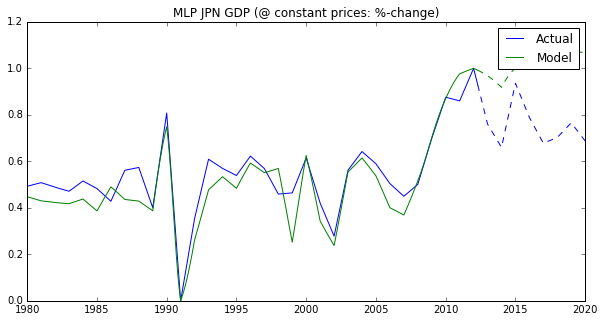

In [13]:
approximation = list()

for datapoint in X_train.index:
    
    #appending the approximation list with the network model 
    approximation.append(mlp_network.ann_prediction( X_train.loc[datapoint].tolist() ))

#preparing the approximations for graphs    
approx = list()
for number in approximation:
    approx.append(number[0])
    
approx = matrix(approx).T
approx = scaler.fit_transform(approx, (0,1))
    
predictions = list()

for datapoint in X_test.index:
    
    #appending the predictions list with network predictions
    predictions.append(mlp_network.ann_prediction( X_test.loc[datapoint].tolist() ))

#preparing the predictions for graphs
pred = list()
for number in predictions:
    pred.append(number[0])
    
pred = matrix(pred).T
pred = scaler.transform(pred)
    
#Graphing the target (Y) data
pyplot.figure(figsize=(10,5))
pyplot.plot(T_train, Y_train, 'b')
pyplot.plot(T_train, approx, 'g')
pyplot.plot(T_test, Y_test, 'b--')
pyplot.plot(T_test, pred, 'g--')
pyplot.legend(["Actual", "Model"])

#selection for graph title depending on the data used
if japanese:
    pyplot.title('MLP JPN GDP (@ constant prices: %-change)')
else:
    pyplot.title('MLP UK GDP (@ constant prices: %-change)')
pyplot.show()

In [14]:
#Detemrining relative influence of the macroeconomic indicators onto gdp
identity_matrix = [[[0,1][i==feature] for i in range(mlp_network.size["input"])] for feature in range(mlp_network.size["input"])]

analysis = list()
for vector in identity_matrix:
    analysis.append(mlp_network.ann_prediction(vector)[0])

#displaying the macroeconomic influence table; higest and lowest are marked  
print("Relative Influence\t\tName\n-----------------------------------------------------------\n")
for score, name in zip(analysis, X_selected):
    if(score == max(analysis)): 
        mark = '+'
    elif(score == min(analysis)):
        mark = '-'
    else: 
        mark = ''
    
    print("%s\t%0.5f   \t%s"%(mark, abs(score), name))
    
#displaying the macroeconomic influence table in a sorted fashion
print("\n\n\nSORTED\nRelative Influence\t\tName\n-----------------------------------------------------------\n")    
    
for item in pandas.DataFrame(data=transpose([analysis, X_selected]), columns=['score', 'feature'])\
.sort_values("score", ascending=False).as_matrix().tolist():
    score, name = tuple(item)
    print("%s\t%0.5f   \t%s"%(mark, float(score), name))

Relative Influence		Name
-----------------------------------------------------------

	0.86714   	JPN current account balance_usd billions
+	0.99338   	JPN exports of goods and services_% change
	0.92245   	JPN exports of goods_% change
	0.96632   	JPN general government net debt_% of gdp
	0.95887   	JPN general government net lending-borrowing_usd billions
	0.85553   	JPN general government net lending_borrowing_% of gdp
	0.95727   	JPN general government primary net lending-borrowing_usd billions
	0.92175   	JPN general government primary net lending_borrowing_% of gdp billions
	0.79705   	JPN general government revenue_% of gdp
	0.96586   	JPN general government total expenditure_% of gdp
	0.94579   	JPN gross national savings_% of gdp
	0.78558   	JPN inflation % change_average consumer prices
	0.59936   	JPN inflation index_average consumer prices
	0.63242   	JPN inflation index_end of period consumer prices
-	0.54545   	JPN population_millions
	0.94093   	JPN share of world gdp ba

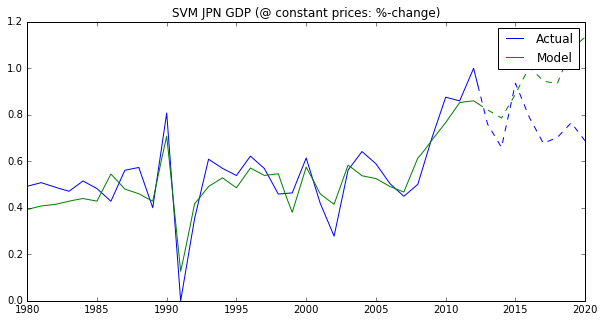

In [15]:
'''Support Vector Machine'''
#comparing against other regression models
import sklearn.svm as svm

#setting the regressor to svm
regressor = svm.SVR()
regressor.fit(X_train, Y_train)

approx_svm = list()

#appending the approx_svm list with the model fitting 
for datapoint in X_train.index:
    approx_svm.append(regressor.predict(matrix(X_train.loc[datapoint])).tolist()[0])
    
predict_svm = list()

#appending predict_svm list with the predictions
for datapoint in X_test.index:
    predict_svm.append(regressor.predict(matrix(X_test.loc[datapoint])).tolist()[0])

#displaying the output respective to svm
pyplot.figure(figsize=(10,5))
pyplot.plot( T_train, Y_train, 'b' )
pyplot.plot( T_train, approx_svm, 'g' )
pyplot.plot( T_test,  Y_test, 'b--' )
pyplot.plot( T_test, predict_svm, 'g--')
pyplot.legend(["Actual", "Model"])

#selection for graph title depending on the data used
if japanese:
    pyplot.title('SVM JPN GDP (@ constant prices: %-change)')
else:
    pyplot.title('SVM UK GDP (@ constant prices: %-change)')
pyplot.show()

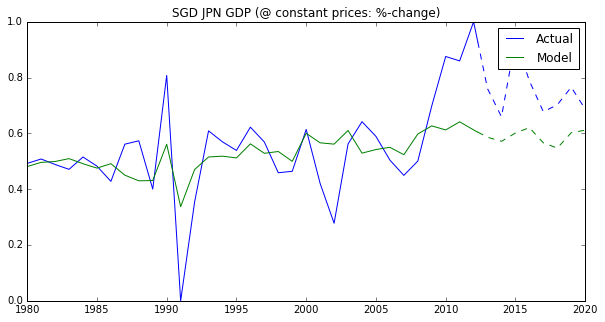

In [16]:
'''Stochastic Gradient Descent'''
#loading sklearn libraries
import sklearn.linear_model as linear_model

#setting the regressor to sgd
regressor = linear_model.SGDRegressor()
regressor.fit(X_train, Y_train)

approx_sgd = list()

#appending approx_sgd list with the model fitting
for datapoint in X_train.index:
    approx_sgd.append(regressor.predict(matrix(X_train.loc[datapoint])).tolist()[0])
    
predict_sgd = list()

#appending predict_sgd list with the predictions
for datapoint in X_test.index:
    predict_sgd.append(regressor.predict(matrix(X_test.loc[datapoint])).tolist()[0])

#displaying the output respective to sgd 
pyplot.figure(figsize=(10,5))
pyplot.plot( T_train, Y_train, 'b' )
pyplot.plot( T_train, approx_sgd, 'g' )
pyplot.plot( T_test,  Y_test, 'b--' )
pyplot.plot( T_test, predict_sgd, 'g--')
pyplot.legend(["Actual", "Model"])

#selection for graph title depending on the data used
if japanese:
    pyplot.title('SGD JPN GDP (@ constant prices: %-change)')
else:
    pyplot.title('SGD UK GDP (@ constant prices: %-change)')
pyplot.show()

<font color='red'> pybrain code: start </font>

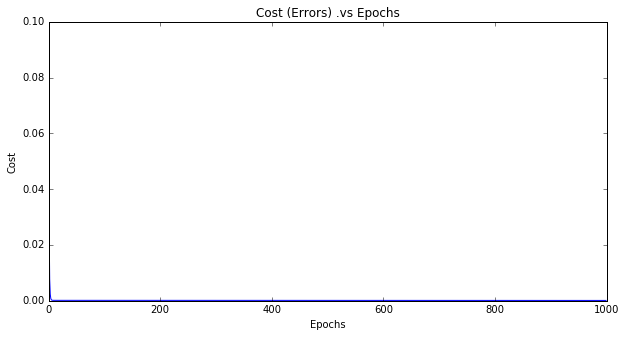

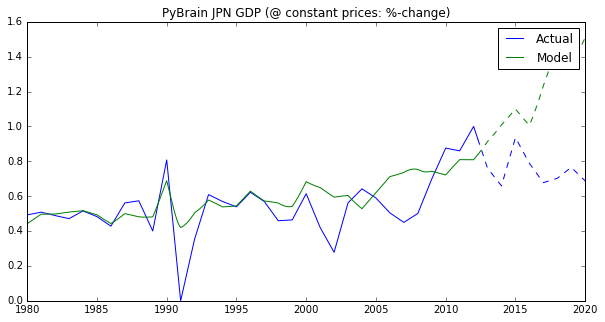

In [17]:
#ANN imported from pybrain to test against my ANN

#setting the hidden size & number of epochs
hidden_size = 10
max_epoch = 1000

'''########'''
#Learning
#creating pybrain dataset
import pybrain.datasets as datasets

dataset = datasets.SupervisedDataSet(mlp_network.size["input"], 1)

for datapoint, _ in enumerate(X_train):
    dataset.addSample(tuple(X_train.loc[datapoint].tolist()), Y_train.loc[datapoint].tolist())

#creating pybrain network
from pybrain.tools.shortcuts import buildNetwork

network = buildNetwork(mlp_network.size["input"], mlp_network.size["hidden"], 1)
    
#creating pybrain learning algorithm
import pybrain.supervised.trainers as trainers

trainer = trainers.BackpropTrainer(network, dataset)

cost = list()

#updating and appending the error list
for epoch in range(max_epoch):
    cost.append(trainer.train())

#displaying the error vs the number of epochs
pyplot.figure(figsize=(10,5))
pyplot.plot(cost)
pyplot.title("Cost (Errors) .vs Epochs")
pyplot.xlabel("Epochs")
pyplot.ylabel("Cost")


approximation = list()

#appending the approximation list with the model fitting
for datapoint in X_train.index: 
    approximation.append(network.activate(tuple(X_train.loc[datapoint].tolist())))

prediction = list()

#appending the prediction list with the prediction
for datapoint in X_test.index: 
    prediction.append(network.activate(tuple(X_test.loc[datapoint].tolist())))

#displaying the model against the actual
pyplot.figure(figsize=(10,5))
pyplot.plot(T_train, Y_train, 'b')
pyplot.plot(T_train, approximation, 'g')
pyplot.plot(T_test, Y_test, 'b--')
pyplot.plot(T_test, prediction, 'g--')
pyplot.legend(["Actual", "Model"])

#selection for graph title depending on the data used
if japanese:
    pyplot.title('PyBrain JPN GDP (@ constant prices: %-change)')
else:
    pyplot.title('PyBrain UK GDP (@ constant prices: %-change)')
pyplot.show()

<font color='red'> pybrain code: end </font>